# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from transformers import BertTokenizerFast, BertModel, AdamW
from torch.utils.data import TensorDataset, DataLoader

import time
from tqdm.notebook import tqdm

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)



cuda:0


# Preprocessing Data

In [2]:
df = pd.read_csv('/kaggle/input/human-vs-llm-text-corpus/data.csv', usecols=['text', 'source']) 
df['source'] = df['source'].apply(lambda x: 0 if x == 'Human' else 1)
df = df.rename(columns={'source': 'generated'})
df.head()

,text,generated
0,"Federal law supersedes state law, and cannabis...",1
1,Miles feels restless after working all day. He...,1
2,So first of I am danish. That means that I fol...,1
3,In this paper we present a novel rule-based ap...,1
4,"Most social progressives, love democracy, and ...",1


In [3]:
def tokenize_and_encode(tokenizer, comments, labels, max_length=128): 
    input_ids = [] 
    attention_masks = [] 

    for comment in comments: 
        encoded_dict = tokenizer.encode_plus( 
            comment,  
            add_special_tokens=True, 
            max_length=max_length, 
            pad_to_max_length=True, 
            return_attention_mask=True, 
            return_tensors='pt'
        ) 

        input_ids.append(encoded_dict['input_ids']) 
        attention_masks.append(encoded_dict['attention_mask']) 

    input_ids = torch.cat(input_ids, dim=0) 
    attention_masks = torch.cat(attention_masks, dim=0) 

    labels = torch.tensor(labels, dtype=torch.float32) 
    
    return input_ids, attention_masks, labels 

In [4]:
max_len = 400
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', \
                                              do_lower_case=True)

test_input_ids, test_attention_masks, test_labels = tokenize_and_encode( 
                                                tokenizer, 
                                                df.text.tolist(), 
                                                df.generated.tolist(),
                                                max_length = max_len
                                            ) 



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad

In [5]:
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels) 
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model Construction

In [6]:

# initialguess for the archetecture is [768, 512, 256, 128, 1]
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim):
        super(MLP, self).__init__()
        self.fc1  = nn.Linear(input_dim, hidden_dim1)
        self.fc2  = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3  = nn.Linear(hidden_dim2, hidden_dim3)
        self.fc4  = nn.Linear(hidden_dim3, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.batchnorm1 = nn.BatchNorm1d(hidden_dim1)
        self.batchnorm2 = nn.BatchNorm1d(hidden_dim2)
        self.batchnorm3 = nn.BatchNorm1d(hidden_dim3)

    def forward(self, x):
        x = self.fc1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.fc4(x)
        return x
            
        
class CombinedModel(nn.Module):
    def __init__(self, bert_model, mlp):
        super(CombinedModel, self).__init__()
        self.bert = bert_model
        self.mlp = mlp

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state[:, 0, :]
        logits = self.mlp(last_hidden_state)
        return logits


In [7]:
bert_model = BertModel.from_pretrained('bert-base-uncased')
mlp = MLP(768, 512, 256, 128, 2)
model = CombinedModel(bert_model, mlp).to(device)

checkpoint = torch.load('/kaggle/input/llm-detect/checkpoint.pth')
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/tmp/ipykernel_22/4048914822.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/kaggle/input/llm-detect/checkpoint.pth')


# Testing on a Large Dataset

In [8]:
def testing(model, val_loader, loss_fn):
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    y_pred = []
    y_true = []
    with torch.no_grad():
        for batch in tqdm(val_loader):
            input_ids, attention_mask, labels = [t.to(device) for t in batch]
            outputs = model(input_ids, attention_mask=attention_mask) #, labels=labels)
            loss = loss_fn(outputs.to(device), labels.type(torch.LongTensor).to(device))
            val_loss += loss
            val_correct += (torch.max(outputs.data, dim=1)[1] == labels).sum().item()
            val_total += len(labels)
            
            y_pred.extend(torch.softmax(outputs.data, dim=1)[:, 1].cpu().numpy())  # Assuming class 1 probability
            y_true.extend(labels.cpu().numpy())

            val_correct += (torch.max(outputs.data, dim=1)[1] == labels).sum().item()
            val_total += len(labels)
    
    y_pred_label = [int(num >= 0.5) for num in y_pred]
    roc_auc = roc_auc_score(y_true, y_pred_label)
    precision = precision_score(y_true, y_pred_label)
    recall = recall_score(y_true, y_pred_label)
    f1 = f1_score(y_true, y_pred_label)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    val_loss = val_loss / val_total
    val_accuracy = 100 * val_correct / val_total
    return y_pred_label, val_loss, val_accuracy, roc_auc, precision, recall, f1, fpr, tpr


In [9]:
predictions, loss, acc, roc_auc, precision, recall, f1, fpr, tpr = testing(model, test_loader, loss_fn)

  0%|          | 0/24654 [00:00<?, ?it/s]

In [10]:
print(f"Loss: {loss:.4f}, Acc: {acc:.4f}")
print(f"AOC ROC: {roc_auc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, ")

Loss: 0.0335, Acc: 67.2780
AOC ROC: 0.6406, Precision: 0.6472, Recall: 0.9122, F1: 0.7572, 


In [11]:
df = pd.read_csv('/kaggle/input/human-vs-llm-text-corpus/data.csv')
df['predictions'] = predictions
df.to_csv('output.csv', index=False)

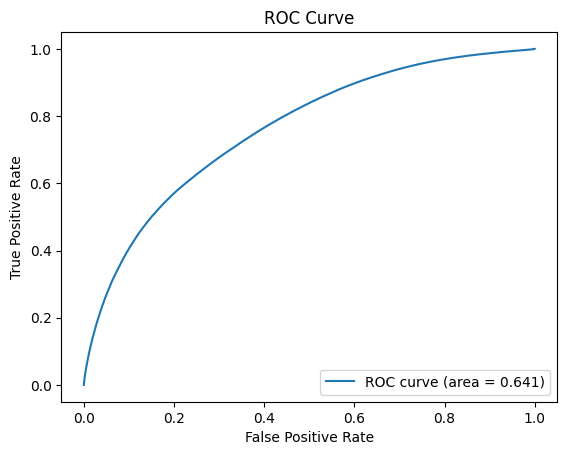

In [12]:
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [13]:
# calculating the Comfusion Matrix
def calculate_tp_tn_fp_fn(accuracy, precision, recall, total_entries):
    tp = np.round((1-accuracy) * total_entries / (1/precision + 1/recall -2))
    fn = np.round((1/recall - 1) *tp)
    fp = np.round((1/precision - 1) *tp)
    tn = np.round(total_entries - tp - fp - fn)
    return tp, fn, fp, tn
array = np.array(calculate_tp_tn_fp_fn(acc/100, \
                                        precision,\
                                        recall, \
                                        len(val_texts)))
matrix = np.array([[array[0], array[1]], [array[2], array[3]]])

plt.matshow(matrix * 1/len(val_texts), cmap=plt.cm.Blues, )

for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        plt.text(x=j, y=i,s=matrix[i, j], va='center', ha='center', size='xx-large')
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

NameError: name 'val_texts' is not defined